# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.7 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import deque, namedtuple


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size*num_agents, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model."""
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size*num_agents, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units + action_size * num_agents, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [8]:
class DDPGAgent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object."""
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
                
        # Noise process
        self.noise = OUNoise((1, action_size), random_seed)

        # Replay or Prioritized Replay Memory
        self.memory = ReplayBuffer(BATCH_SIZE, BUFFER_SIZE, random_seed, ALPHA)
    
    def append_sample(self, state, action, reward, next_state, done, full_action_ext):
        """ save sample (s,a,r,s',d,e) to the prioritized experience replay memory"""
               
        self.actor_target.eval()
        self.critic_target.eval()
        self.critic_local.eval()

        with torch.no_grad():  
            # Predicted Q value from Critic target network
            Q_targets_next = self.critic_target(next_state, full_action_ext)
            Q_targets = reward + (GAMMA * Q_targets_next * torch.tensor(float(1 - done)).to(device))

            # Actual Q value based on reward rec'd at next step + future expected reward from Critic target network

            Q_expected = self.critic_local(state, action)
            
        error = (Q_expected - Q_targets)**2
        self.memory.add(state, action, reward, next_state, done, error)

        self.critic_local.train()
        self.actor_target.train()
        self.critic_target.train()

    def act(self, states, add_noise, eps):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        actions = np.zeros((1, self.action_size))
        self.actor_local.eval()
        with torch.no_grad():
            for agent_num, state in enumerate(states):
                action = self.actor_local(state).cpu().data.numpy()
                actions[agent_num, :] = action
        self.actor_local.train()
        if add_noise:
            actions += eps * self.noise.sample()
        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma, agent_number, actions_next, actions_pred):
        """Update policy and value parameters using given batch of experience tuples."""
        states, actions, rewards, next_states, dones, is_weight, idxs = experiences
                   
        # Predicted Q value from Critic target network
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Actual Q value based on reward received at next step plus future expected rewards from Critic target network
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)

        # Update priority in PER
        loss  = (Q_expected - Q_targets).pow(2).reshape(is_weight.shape) * is_weight
        self.memory.update(idxs, loss.data.cpu().numpy())

        # Minimize critic loss
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters."""
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
            
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0.0, theta=0.13, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store prioritized experience tuples."""

    def __init__(self, batch_size, buffer_size, seed, alpha):
        """Initialize a ReplayBuffer object."""

        self.memory = deque(maxlen=buffer_size)
        self.priorities = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.alpha = alpha
        self.epsilon = 1e-5       
          
    def add(self, state, action, reward, next_state, done, priority):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        self.priorities.append(priority)
    
    def sample(self, beta):
        """Randomly sample a batch of experiences from memory."""
        priorities = np.array(self.priorities).reshape(-1)
        priorities = np.power(priorities + self.epsilon, self.alpha)  # add a small value epsilon to ensure numeric stability
        p = priorities/np.sum(priorities)  # compute a probability density over the priorities
        sampled_indices = np.random.choice(np.arange(len(p)), size=self.batch_size, p=p)  # choose random indices given p
        experiences = [self.memory[i] for i in sampled_indices]     # subset the experiences
        p = np.array([p[i] for i in sampled_indices]).reshape(-1)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        weights = np.power(len(experiences) * p, -beta)
        weights /= weights.max()
        weights = torch.from_numpy(weights).float().to(device)

        return (states, actions, rewards, next_states, dones, weights, sampled_indices)

    def update(self, indices, priorities):
        """Update the priority values after training given the samples drawn."""
        for i, priority in zip(indices, priorities):
            self.priorities[i] = priority

    def ready(self):
        """Return the current size of internal memory."""
        return len(self.memory) >= self.batch_size

In [9]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128
GAMMA = 0.99            # discount factor
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 3e-4        # learning rate of the critic
TAU = 5e-3              # for soft update of target parameters
WEIGHT_DECAY = 0        # L2 weight decay

ALPHA = 0               # PER 1 = full prioritization, 0 = no prioritization
BETA_START = 0          # PER - What degree to use importance weights (0 - no corrections, 1 - full correction)


In [20]:
# share current action rather than predict action in both actor target and actor local
SHARE_ACTUAL_ACTION = False

class MADDPGAgent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, num_agents):
        self.t_step = 0
        self.whole_action_dim = action_size*num_agents
        
        self.actor_loss = []
        self.critic_loss = []
        
        self.agent=[]
        for i in range(num_agents):
            self.agent.append(DDPGAgent(state_size, action_size, random_seed = 0))
        
    def reset(self):
        for i in range(num_agents):
            self.agent[i].reset()
            
    def act(self, states, add_noise, eps):
        action_0 = self.agent[0].act(states, ADD_NOISE, eps)           # select an action (for each agent)
        action_1 = self.agent[1].act(states, ADD_NOISE, eps)           # select an action (for each agent)
        actions = np.concatenate((action_0, action_1), axis=0).reshape(1,4)
        return actions
        
    # in this case, for easier debugging, I assume there are only 2 agents
    def step(self, state, action, reward, next_state, done, beta, episode):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        self.t_step += 1
        action_next = []
        
        state = torch.from_numpy(state).float().to(device)
        next_state = torch.from_numpy(next_state).float().to(device)
        action = torch.from_numpy(action).float().to(device)
        
        if (SHARE_ACTUAL_ACTION):
            action_next_0 = self.agent[0].actor_target.forward(next_state)
            action_next_1 = self.agent[1].actor_target.forward(next_state)
            action_next.append(torch.cat((action_next_0, action[:,2:]), dim=1))
            action_next.append(torch.cat((action[:,:2], action_next_1), dim=1))
        else:
            action_next_0 = self.agent[0].actor_target.forward(next_state)
            action_next_1 = self.agent[1].actor_target.forward(next_state)
            action_next.append(torch.cat((action_next_0, action_next_1), dim=1))
            action_next.append(torch.cat((action_next_0, action_next_1), dim=1))

        for i in range(num_agents):
            self.agent[i].append_sample(state, action, reward[i], next_state, done, action_next[i])
            # Learn, if enough samples are available in memory
            if self.agent[i].memory.ready() and episode > 100:
                full_actions_next = []
                full_actions_actor = []

                experiences = self.agent[i].memory.sample(beta)
                states, actions, rewards, next_states, dones, weights, sampled_indices = experiences

                # Get predicted next-state actions and Q values from target models
                if (SHARE_ACTUAL_ACTION):
                    actions_next = self.agent[i].actor_target.forward(next_states)
                    full_actions_next.append(torch.cat((actions_next, actions[:,2:]), dim=1))
                    full_actions_next.append(torch.cat((actions[:,:2], actions_next), dim=1))
                else:
                    actions_next_0 = self.agent[0].actor_target.forward(next_states)
                    actions_next_1 = self.agent[1].actor_target.forward(next_states)
                    full_actions_next.append(torch.cat((actions_next_0, actions_next_1), dim=1))
                    full_actions_next.append(torch.cat((actions_next_0, actions_next_1), dim=1))

                if (SHARE_ACTUAL_ACTION):
                    actor_actions = self.agent[i].actor_local.forward(states)
                    full_actions_actor.append(torch.cat((actor_actions, actions[:,2:]), dim=1))
                    full_actions_actor.append(torch.cat((actions[:,:2], actor_actions), dim=1))
                else:
                    actor_actions_0 = self.agent[0].actor_local.forward(states)
                    actor_actions_1 = self.agent[1].actor_local.forward(states)
                    full_actions_actor.append(torch.cat((actor_actions_0, actor_actions_1), dim=1))
                    full_actions_actor.append(torch.cat((actor_actions_0, actor_actions_1), dim=1))

                self.agent[i].learn(experiences, GAMMA, i , full_actions_next[i], full_actions_actor[i])


    def save(self, filename):
        for i in range(num_agents):
            torch.save(self.agent[i].critic_local.state_dict(), filename + str(i) + "_critic.pth")
            torch.save(self.agent[i].actor_local.state_dict(), filename + str(i) +"_actor.pth")
            
    def load(self, filename):
        for i in range(num_agents):
            self.agent[i].critic_local.load_state_dict(torch.load(filename + str(i) + "_critic.pth", map_location='cpu'))
            self.agent[i].actor_local.load_state_dict(torch.load(filename + str(i) + "_actor.pth", map_location='cpu'))

In [ ]:
ADD_NOISE = True
NOISE_START = 5
NOISE_END = 0
NOISE_DECAY = 100

agent = MADDPGAgent(state_size, action_size, 2)

beta_schedule = lambda episode: min(1.0, BETA_START + episode * (1.0 - BETA_START) / n_episodes)
noise_schedule = lambda episode: max(NOISE_END, NOISE_START - episode * ((NOISE_START - NOISE_END) / NOISE_DECAY))


In [12]:
print_every = 10
scores_deque = deque(maxlen=print_every)

scores_all = []

n_episodes = 2000
t_max = 500

for i_episode in range(1, n_episodes+1):
    beta = beta_schedule(i_episode)
    eps = noise_schedule(i_episode)
    #print (eps)
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    states = env_info.vector_observations
    states = np.reshape(states, (1,48))
    agent.reset()
    scores = np.zeros(num_agents)
    
    for steps in range(t_max):
        actions = agent.act(states, ADD_NOISE, eps)
        env_info = env.step(actions)[brain_name]           # send all actions to the environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        next_states = np.reshape(next_states, (1, 48))
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                         # see if episode finished
        done = np.any(dones)                               # if either agent fails, episode over            
        
        agent.step(states, actions, rewards, next_states, done, beta, i_episode)
            
        scores += rewards                                  # update the score (for each agent)
        states = next_states                                # roll over states to next time step
        
        if done:                                  # exit loop if episode finished
            break
            
    episode_reward = np.max(scores)
    scores_deque.append(episode_reward)
    scores_all.append(episode_reward)
    print('\rEpisode {}\tAverage Score: {:.3f}\tScore: {:.3f}\tSteps: {:.4f}'.format(i_episode, np.mean(scores_deque), episode_reward, steps), end="")
    if i_episode % print_every == 0:    
        print('\rEpisode {}\tAverage Score: {:.3f}\tMax Score: {:.2f}'.format(i_episode, np.mean(scores_deque), np.max(scores_deque)))
        agent.save("checkpoint")

    if np.mean(scores_deque) > 1.0:
        print('\rFinished at Episode {}\tReach Average Score: {:.3f}!'.format(i_episode, np.mean(scores_deque)))
        agent.save("checkpoint")
        break

Episode 100	Average Score: 0.038	Max Score: 0.20
Episode 200	Average Score: 0.373	Max Score: 2.60
Finished at Episode 246	Reach Average Score: 1.020!


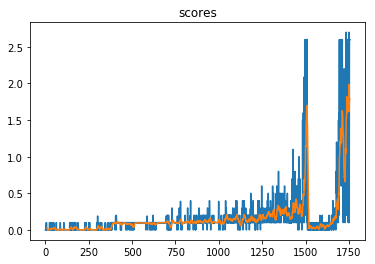

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def plot_scores(scores, rolling_window=10, title = "scores"):
    """Plot scores and optional rolling mean using specified window."""
    plt.plot(scores); 
    plt.title(title);
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    return rolling_mean

rolling_mean = plot_scores(scores_all)

In [28]:
agent = MADDPGAgent(state_size, action_size, 2)
agent.load("checkpoint")
    
for i in range(10):
    eps = 0
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    states = np.reshape(states, (1,48))
    steps = 0
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)

    while True:
        #actions = policy.select_actions(np.array(states))
        #actions = np.clip(actions, -1, 1)
        actions = agent.act(states, ADD_NOISE, eps)
        
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        next_states = np.reshape(next_states, (1, 48))
        
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        
        steps += 1
        if np.any(dones):                                  # exit loop if episode finished
            print (scores, steps)
            break
            
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))


[ 1.20000002  1.29000002] 486
[ 2.60000004  2.60000004] 1001
[ 0.80000001  0.89000002] 324
[ 0.40000001  0.29      ] 147
[ 0.1  -0.01] 36
[ 2.60000004  2.60000004] 1001
[ 0.70000001  0.79000001] 283
[ 0.2   0.09] 77
[ 1.10000002  1.09000002] 433
[ 1.00000001  1.09000002] 408
Total score (averaged over agents) this episode: 1.045000015757978
